In [57]:
import os, itertools
from glob import glob

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

import numpy as np
from PIL import Image

# Hyperparameter

In [58]:
seed = 1

IMG_HEIGHT = 128
IMG_WIDTH = 128

lr = 0.001
beta = 3

epochs = 30
log_interval = 2

no_cuda = False

use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print('Num_GPU :', torch.cuda.device_count())
batch_size = 128 * torch.cuda.device_count()
test_batch_size = 128 * torch.cuda.device_count()

batch_size = 2 * torch.cuda.device_count()
test_batch_size = 1

torch.manual_seed(seed)

kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

Num_GPU : 2


# Model

In [59]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #f1
        self.conv1 = nn.Conv2d(3, 64, 5, 2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(inplace=True)

        self.conv2 = nn.Conv2d(3, 64, 5, 2, 2)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.LeakyReLU(inplace=True)
       
        #f2
        self.conv3 = nn.Conv2d(128, 128, 5, 2, 2)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.LeakyReLU(inplace=True)

        self.conv4 = nn.Conv2d(128, 128, 5, 2, 2)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.LeakyReLU(inplace=True)
       
        #f3
        self.conv5 = nn.Conv2d(256, 128, 5, 2, 2)
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5 = nn.LeakyReLU(inplace=True)

        self.conv6 = nn.Conv2d(256, 128, 5, 2, 2)
        self.bn6 = nn.BatchNorm2d(128)
        self.relu6 = nn.LeakyReLU(inplace=True)
       
        #f4
        self.conv7 = nn.Conv2d(256, 256, 5, 2, 2)
        self.bn7 = nn.BatchNorm2d(256)
        self.relu7 = nn.LeakyReLU(inplace=True)

        self.conv8 = nn.Conv2d(256, 256, 5, 2, 2)
        self.bn8 = nn.BatchNorm2d(256)
        self.relu8 = nn.LeakyReLU(inplace=True)
       
        #encode
        self.fc1 = nn.Linear(int(IMG_HEIGHT/16)*int(IMG_WIDTH/16)*512, 256)
        self.fc2 = nn.Linear(256,int(IMG_HEIGHT/16)*int(IMG_WIDTH/16)*256)
        
        #d1
        self.conv9 = nn.ConvTranspose2d(256, 128, 5, 2, 2, 1)
        self.bn9 = nn.BatchNorm2d(128)
        self.relu9 = nn.LeakyReLU(inplace=True)
        
        #d1_uni
        self.conv10 = nn.ConvTranspose2d(256, 256, 5, 1, 2)
        self.bn10 = nn.BatchNorm2d(256)
        self.relu10 = nn.LeakyReLU(inplace=True)
        
        #d2
        self.conv11 = nn.ConvTranspose2d(256, 128, 5, 2, 2, 1)
        self.bn11 = nn.BatchNorm2d(128)
        self.relu11 = nn.LeakyReLU(inplace=True)       

        #d2_uni
        self.conv12 = nn.Conv2d(256, 256, 5, 1, 2)
        self.bn12 = nn.BatchNorm2d(256)
        self.relu12 = nn.LeakyReLU(inplace=True)  

        #d3
        self.conv13 = nn.ConvTranspose2d(256, 64, 5, 2, 2, 1)
        self.bn13 = nn.BatchNorm2d(64)
        self.relu13 = nn.LeakyReLU(inplace=True)          

        #d3_uni
        self.conv14 = nn.Conv2d(128, 128, 5, 1, 2)
        self.bn14 = nn.BatchNorm2d(128)
        self.relu14 = nn.LeakyReLU(inplace=True) 
        
        #decode
        self.conv15 = nn.ConvTranspose2d(128, 3, 5, 2, 2, 1)
        self.conv16 = nn.ConvTranspose2d(128, 1, 5, 2, 2, 1)
        
    def forward(self, x):
        f1_1 = self.relu1(self.bn1(self.conv1(x))) #64x64x64
        f1_2 = self.relu2(self.bn2(self.conv2(x))) #64x64x64
        
        f1 = torch.cat((f1_1, f1_2), 1) #128x64x64
        
        f2_1 = self.relu3(self.bn3(self.conv3(f1))) #128x32x32
        f2_2 = self.relu4(self.bn4(self.conv4(f1))) #128x32x32

        f2 = torch.cat((f2_1, f2_2), 1) #256x32x32
        
        f3_1 = self.relu5(self.bn5(self.conv5(f2))) #128x16x16
        f3_2 = self.relu6(self.bn6(self.conv6(f2))) #128x16x16
        
        f3 = torch.cat((f3_1, f3_2), 1) #256x16x16

        f4_1 = self.relu7(self.bn7(self.conv7(f3))) #256x8x8
        f4_2 = self.relu8(self.bn8(self.conv8(f3))) #256x8x8
        
        f4 = torch.cat((f4_1, f4_2), 1) #512x8x8

        x = f4.view(f4.size(0), -1)
        encode = self.fc1(x) #256
        
        d1 = self.fc2(encode) #256x8x8
        d1 = self.relu9(self.bn9(self.conv9(d1.view(-1,256,int(IMG_HEIGHT/16),int(IMG_WIDTH/16))))) #128x16x16
             
        d1_uni = torch.cat((d1, f3_2), 1) #256x16x16
        d1_uni = self.relu10(self.bn10(self.conv10(d1_uni))) #256x16x16
        
        d2 = self.relu11(self.bn11(self.conv11(d1_uni))) #128x32x32
        
        d2_uni = torch.cat((d2, f2_2), 1) #256x32x32
        d2_uni = self.relu12(self.bn12(self.conv12(d2_uni))) #256x32x32
        
        d3 = self.relu13(self.bn13(self.conv13(d2_uni))) #64x64x64
        
        d3_uni = torch.cat((d3, f1_2), 1) #128x64x64
        d3_uni = self.relu14(self.bn14(self.conv14(d3_uni))) #128x64x64

        rec = self.conv15(d3_uni) #3x128x128
        mask = self.conv16(d3_uni) #1x128x128
        
        return torch.sigmoid(rec), torch.sigmoid(mask)

# Preprocess

In [60]:
train_paths = glob('C:/Users/IVCL/Desktop/duck/no_circle/train/image/*.png')
test_paths = glob('C:/Users/IVCL/Desktop/duck/real/test/image/*.png')
val_paths = glob('C:/Users/IVCL/Desktop/duck/real/val/image/*.png')
len(train_paths), len(test_paths), len(val_paths)

(20000, 253, 1000)

In [61]:
def get_label(path):
    rec_path = path[:-20]+'rec/'+path[-14:]
    rec = Image.open(rec_path).convert("RGB")
    rec = np.array(rec)
    #label = np.where(label>0,1.0,0)
    rec = torch.from_numpy(rec/255)
    rec = rec.permute(2,0,1)
    
    mask_path = path[:-20]+'label/'+path[-14:]
    mask = Image.open(mask_path)
    mask = np.array(mask)
    mask = np.where(mask>0,1.0,0)
    mask = torch.from_numpy(mask)
    mask = mask.unsqueeze_(0)
    
    return rec.float(), mask.float()

In [62]:
class Dataset(Dataset):
    def __init__(self, data_paths, transform=None):

        self.data_paths = data_paths
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        path = self.data_paths[idx]
        # Read Image
        image = Image.open(path).convert("RGB")
        
        #Get Label
        rec, mask = get_label(path)
        
        if self.transform:
            image = self.transform(image)

        return image, rec, mask

In [63]:
train_loader = torch.utils.data.DataLoader(
    Dataset(train_paths, 
            transforms.Compose([
                #transforms.RandomHorizontalFlip(), 
                transforms.ToTensor(), 
                transforms.Normalize(
                    mean=[0.406, 0.406, 0.406], 
                    std=[0.225, 0.225, 0.225])])
           ),
    batch_size=batch_size, 
    shuffle=True, 
    **kwargs
)

val_loader = torch.utils.data.DataLoader(
    Dataset(val_paths,
           transforms.Compose([
               transforms.ToTensor(), 
               transforms.Normalize(
                   mean=[0.406, 0.406, 0.406], 
                   std=[0.225, 0.225, 0.225])])
           ),
    batch_size=test_batch_size, 
    shuffle=False, 
    **kwargs
)

test_loader = torch.utils.data.DataLoader(
    Dataset(test_paths,
           transforms.Compose([
               transforms.ToTensor(), 
               transforms.Normalize(
                   mean=[0.406, 0.406, 0.406], 
                   std=[0.225, 0.225, 0.225])])
           ),
    batch_size=test_batch_size, 
    shuffle=False, 
    **kwargs
)

In [64]:
for i, (data, rec, mask) in enumerate(train_loader):
    if i == 0:
        print(data[0].shape, rec[0].shape, mask[0].shape)
        break

torch.Size([3, 128, 128]) torch.Size([3, 128, 128]) torch.Size([1, 128, 128])


# Optimization

In [65]:
model = Net()
model = nn.DataParallel(model)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

In [66]:
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           4,864
            Conv2d-2           [-1, 64, 64, 64]           4,864
       BatchNorm2d-3           [-1, 64, 64, 64]             128
         LeakyReLU-4           [-1, 64, 64, 64]               0
       BatchNorm2d-5           [-1, 64, 64, 64]             128
            Conv2d-6           [-1, 64, 64, 64]           4,864
         LeakyReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]           4,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
        LeakyReLU-10           [-1, 64, 64, 64]               0
      BatchNorm2d-11           [-1, 64, 64, 64]             128
           Conv2d-12          [-1, 128, 32, 32]         409,728
        LeakyReLU-13           [-1, 64, 64, 64]               0
      BatchNorm2d-14          [-1, 128,

# Visualization

In [67]:
def visualization(model, test_path, rec_path, mask_path):
    model.eval()
    model.to(device)
    transform = transforms.Compose([
                   transforms.ToTensor(), 
                   transforms.Normalize(
                       mean=[0.406, 0.406, 0.406], 
                       std=[0.225, 0.225, 0.225])])

    image = Image.open(test_path).convert("RGB")
    image = transform(image).unsqueeze_(0)
    rec_result, mask_result = model(image)
    rec_result, mask_result = rec_result.permute(0,2,3,1).to('cpu').detach().numpy(), mask_result.to('cpu').detach().numpy()
    mask_result = np.where(mask_result[0,:,:,:]>=0.5, 1.0, 0)
    
    test_image = plt.imread(test_path)
    rec_image = plt.imread(rec_path)
    mask_image = plt.imread(mask_path)
    plt.figure(figsize=(20,20))
    display_list = [test_image, rec_image, rec_result[0,:,:,:], mask_image, mask_result[0,:,:]]
    title = ['Input Image', 'Ground Truth(Rec)', 'Predicted(Rec)','Ground Truth(Mask)', 'Predicted(Mask)']
    
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

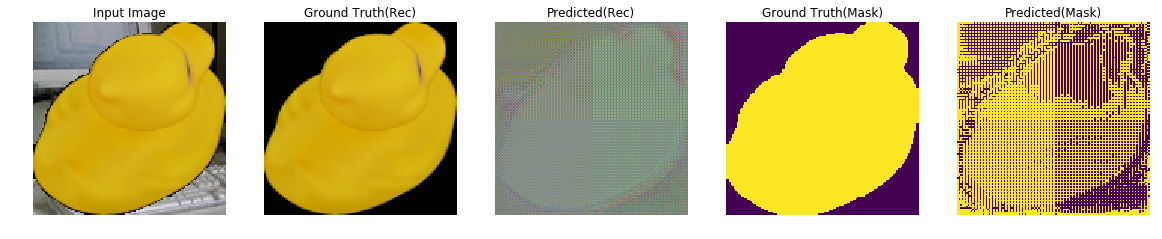

In [68]:
test_path = 'C:/Users/IVCL/Desktop/duck/no_circle/train/image/duck_00001.png'
rec_path = 'C:/Users/IVCL/Desktop/duck/no_circle/train/rec/duck_00001.png'
mask_path = 'C:/Users/IVCL/Desktop/duck/no_circle/train/label/duck_00001.png'
visualization(model, test_path, rec_path, mask_path)

# Training

In [75]:
checkpoint_path = './checkpoints_tc120_no_circle_occlusionX_reconstruction2_beta3_stride'

In [14]:
loss_list = []
val_loss_list = []
rec_loss_list = []
val_rec_loss_list = []
mask_loss_list = []
val_mask_loss_list = []

for epoch in range(1, epochs + 1):
    # Train Mode
    model.to(device).train()

    train_loss_sum = 0
    val_loss_sum = 0 
    train_rec_loss_sum = 0
    val_rec_loss_sum = 0 
    train_mask_loss_sum = 0
    val_mask_loss_sum = 0     
    
    cut_num = 10 # 1 epoch당 train할 batch_idx (256 * 10 = 2560)
    
    for batch_idx, (data, rec_target, mask_target) in enumerate(train_loader):
        
        data, rec_target, mask_target = data.to(device), rec_target.to(device), mask_target.to(device)
        optimizer.zero_grad()
        rec_output, mask_output = model(data)
        
        mask_target_reverse = torch.ones(1,IMG_HEIGHT,IMG_WIDTH).to(device) - mask_target
        
        multiply = torch.mul(rec_output, mask_target)
        multiply2 = torch.mul(rec_output, mask_target_reverse)
        
        rec_target2 = torch.mul(rec_target, mask_target_reverse)
        
        rec_loss1 = F.mse_loss(multiply, rec_target)
        rec_loss2 = F.mse_loss(multiply2, rec_target2)
        mask_loss = F.binary_cross_entropy(mask_output, mask_target)
        
        rec_loss = rec_loss1*beta + rec_loss2
        
        loss = rec_loss + mask_loss
        
        loss.backward()
        optimizer.step()
        
        train_loss_sum = train_loss_sum + loss.item()
        train_rec_loss_sum = train_rec_loss_sum + rec_loss.item()
        train_mask_loss_sum = train_mask_loss_sum + mask_loss.item()
                
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tRec_Loss: {: 6f}\tMask_Loss: {: 6f}'.format(
                epoch, batch_idx * len(data), cut_num * batch_size,
                100. * batch_idx * len(data) / (cut_num * batch_size), train_loss_sum / ((batch_idx + 1e-7) * len(data)),
                train_rec_loss_sum / ((batch_idx + 1e-7) * len(data)),
                train_mask_loss_sum / ((batch_idx + 1e-7) * len(data))))
            
        if batch_idx == cut_num:
            break
    
    # Test mode
    model.eval()
    val_loss = 0
    val_rec_loss = 0
    val_mask_loss = 0
    
    with torch.no_grad():
        for data, rec_target, mask_target in val_loader:
            data, rec_target, mask_target = data.to(device), rec_target.to(device), mask_target.to(device)
            rec_output, mask_output = model(data)
            
            mask_target_reverse = torch.ones(1,IMG_HEIGHT,IMG_WIDTH).to(device) - mask_target
            
            multiply = torch.mul(rec_output, mask_target)
            multiply2 = torch.mul(rec_output, mask_target_reverse)
            
            rec_target2 = torch.mul(rec_target, mask_target_reverse)
            
            rec_loss1 = F.mse_loss(multiply, rec_target)
            rec_loss2 = F.mse_loss(multiply2, rec_target2)
            
            val_rec_loss = rec_loss1*beta + rec_loss2
            val_mask_loss = F.binary_cross_entropy(mask_output, mask_target)
            
            val_loss = val_rec_loss + val_mask_loss
            
            val_loss_sum = val_loss_sum + val_loss.item()
            val_rec_loss_sum = val_rec_loss_sum + val_rec_loss.item()
            val_mask_loss_sum = val_mask_loss_sum + val_mask_loss.item()
            
    loss_list.append(train_loss_sum / len(train_loader.dataset))
    val_loss_list.append(val_loss_sum / len(val_loader.dataset))
    rec_loss_list.append(train_rec_loss_sum / len(train_loader.dataset))
    val_rec_loss_list.append(val_rec_loss_sum / len(val_loader.dataset)) 
    mask_loss_list.append(train_mask_loss_sum / len(train_loader.dataset))
    val_mask_loss_list.append(val_mask_loss_sum / len(val_loader.dataset)) 
    
    print('\nValidation set: Average Loss: {:.6f}\tRec_Loss: {: 6f}\tMask_Loss: {: 6f}'.format(
        val_loss_sum / len(val_loader.dataset), val_rec_loss_sum / len(val_loader.dataset),
        val_mask_loss_sum / len(val_loader.dataset)))
    
    if epoch % 2 == 0:
        torch.save(model.state_dict(), checkpoint_path+'/epoch-%s.pt'%epoch)

C:\Users\IVCL\Miniconda3\envs\tc120\lib\site-packages\torch\cuda\nccl.py:24: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Train Epoch: 1 [0/2560 (0%)]	Loss: 60835.941695	Rec_Loss:  17273.422563	Mask_Loss:  43562.520295
Train Epoch: 1 [512/2560 (20%)]	Loss: 0.004992	Rec_Loss:  0.001705	Mask_Loss:  0.003287
Train Epoch: 1 [1024/2560 (40%)]	Loss: 0.003018	Rec_Loss:  0.001064	Mask_Loss:  0.001955
Train Epoch: 1 [1536/2560 (60%)]	Loss: 0.002263	Rec_Loss:  0.000798	Mask_Loss:  0.001465
Train Epoch: 1 [2048/2560 (80%)]	Loss: 0.001857	Rec_Loss:  0.000649	Mask_Loss:  0.001208
Train Epoch: 1 [2560/2560 (100%)]	Loss: 0.001599	Rec_Loss:  0.000552	Mask_Loss:  0.001047

Validation set: Average Loss: 0.001948	Rec_Loss:  0.000295	Mask_Loss:  0.001654
Train Epoch: 2 [0/2560 (0%)]	Loss: 4867.528332	Rec_Loss:  1401.498303	Mask_Loss:  3466.029884
Train Epoch: 2 [512/2560 (20%)]	Loss: 0.000732	Rec_Loss:  0.000206	Mask_Loss:  0.000526
Train Epoch: 2 [1024/2560 (40%)]	Loss: 0.000573	Rec_Loss:  0.000163	Mask_Loss:  0.000410
Train Epoch: 2 [1536/2560 (60%)]	Loss: 0.000522	Rec_Loss:  0.000148	Mask_Loss:  0.000374
Train Epoch: 2 [2

Train Epoch: 27 [1024/2560 (40%)]	Loss: 0.000035	Rec_Loss:  0.000009	Mask_Loss:  0.000026
Train Epoch: 27 [1536/2560 (60%)]	Loss: 0.000033	Rec_Loss:  0.000009	Mask_Loss:  0.000024
Train Epoch: 27 [2048/2560 (80%)]	Loss: 0.000032	Rec_Loss:  0.000009	Mask_Loss:  0.000023
Train Epoch: 27 [2560/2560 (100%)]	Loss: 0.000032	Rec_Loss:  0.000008	Mask_Loss:  0.000023

Validation set: Average Loss: 0.002067	Rec_Loss:  0.000142	Mask_Loss:  0.001925
Train Epoch: 28 [0/2560 (0%)]	Loss: 294.153069	Rec_Loss:  90.581607	Mask_Loss:  203.571453
Train Epoch: 28 [512/2560 (20%)]	Loss: 0.000043	Rec_Loss:  0.000013	Mask_Loss:  0.000031
Train Epoch: 28 [1024/2560 (40%)]	Loss: 0.000036	Rec_Loss:  0.000010	Mask_Loss:  0.000026
Train Epoch: 28 [1536/2560 (60%)]	Loss: 0.000034	Rec_Loss:  0.000010	Mask_Loss:  0.000024
Train Epoch: 28 [2048/2560 (80%)]	Loss: 0.000032	Rec_Loss:  0.000009	Mask_Loss:  0.000023
Train Epoch: 28 [2560/2560 (100%)]	Loss: 0.000032	Rec_Loss:  0.000009	Mask_Loss:  0.000023

Validation set: 

# Loss Curve

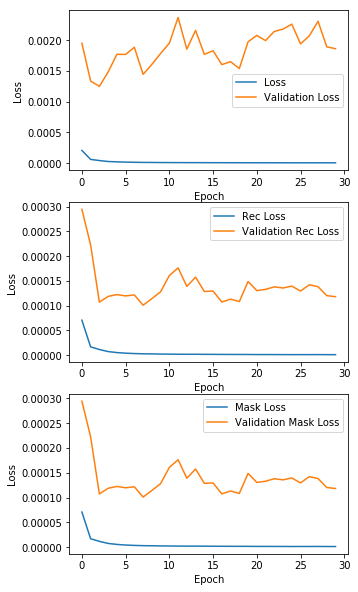

In [15]:
plt.figure(figsize=(5,10))

plt.subplot(3,1,1)
plt.plot(loss_list, label='Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3,1,2)
plt.plot(rec_loss_list, label='Rec Loss')
plt.plot(val_rec_loss_list, label='Validation Rec Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3,1,3)
plt.plot(rec_loss_list, label='Mask Loss')
plt.plot(val_rec_loss_list, label='Validation Mask Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Restore Checkpoint

In [76]:
weight_dict = torch.load(checkpoint_path+'/epoch-10.pt')

In [77]:
model.load_state_dict(weight_dict)

<All keys matched successfully>

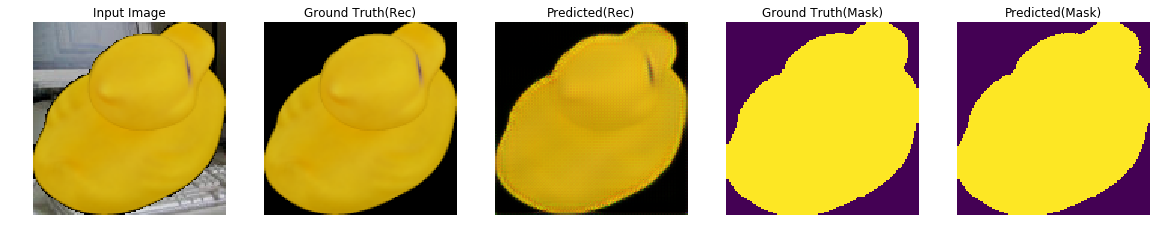

In [78]:
test_path = 'C:/Users/IVCL/Desktop/duck/no_circle/train/image/duck_00001.png'
rec_path = 'C:/Users/IVCL/Desktop/duck/no_circle/train/rec/duck_00001.png'
mask_path = 'C:/Users/IVCL/Desktop/duck/no_circle/train/label/duck_00001.png'

visualization(model, test_path, rec_path, mask_path)

In [16]:
def precision(truth, pred):
    epsilon = 1e-7
    pred = pred.to('cpu').detach().numpy()
    truth = truth.to('cpu').detach().numpy()
    
    pred = np.where(pred >= 0.5, 1.0, 0)
    
    true_positive = np.sum(pred * truth)
    true_positive_false_positive = np.sum(pred)
    
    precision = true_positive / (true_positive_false_positive + epsilon)
                                 
    return precision

                                 
def recall(truth, pred):
    epsilon = 1e-7
    pred = pred.to('cpu').detach().numpy()
    truth = truth.to('cpu').detach().numpy()
    
    pred = np.where(pred >= 0.5, 1.0, 0)
    
    true_positive = np.sum(pred * truth)
    true_positive_false_negative =np.sum(truth)
    
    recall = true_positive / (true_positive_false_negative + epsilon)
                                 
    return recall

In [ ]:
i = 0
for path in test_paths:
    rec_path = path[:-20]+'rec/'+path[-14:]
    mask_path = path[:-20]+'label/'+path[-14:]
    i = i+1
    print('num_image :',i)
    visualization(model, path, rec_path, mask_path)

In [17]:
test_prec = 0
test_rec = 0
num_test = 0
for batch_idx, (data, rec_target, mask_target) in enumerate(test_loader):
    data, rec_target, mask_target = data.to(device), rec_target.to(device), mask_target.to(device)
    rec_output, mask_output = model(data)
    test_prec += precision(mask_target, mask_output)
    test_rec += recall(mask_target, mask_output)
    num_test += 1
    
print('test_precision :',100. * test_prec / num_test, '\ttest_recall :', 100. * test_rec / num_test)

test_precision : 97.47908329724031 	test_recall : 86.7593098759187


In [18]:
params = {
    #model params
    'ngf':32,   #number of generator filters
    'ndf':64,   #number of discriminator filters
    'num_resnet':6, #number of resnet blocks
    'lrG':0.0002,    #learning rate for generator
    'lrD':0.0002,    #learning rate for discriminator
    'beta1':0.5 ,    #beta1 for Adam optimizer
    'beta2':0.999 ,  #beta2 for Adam optimizer
    'lambdaA':10 ,   #lambdaA for cycle loss
    'lambdaB':10  ,  #lambdaB for cycle loss
}

In [19]:
class ConvBlock(torch.nn.Module):
    def __init__(self,input_size,output_size,kernel_size=3,stride=2,padding=1,activation='relu',batch_norm=True):
        super(ConvBlock,self).__init__()
        self.conv = torch.nn.Conv2d(input_size,output_size,kernel_size,stride,padding)
        self.batch_norm = batch_norm
        self.bn = torch.nn.InstanceNorm2d(output_size)
        self.activation = activation
        self.relu = torch.nn.ReLU(True)
        self.lrelu = torch.nn.LeakyReLU(0.2,True)
        self.tanh = torch.nn.Tanh()
    def forward(self,x):
        if self.batch_norm:
            out = self.bn(self.conv(x))
        else:
            out = self.conv(x)
        
        if self.activation == 'relu':
            return self.relu(out)
        elif self.activation == 'lrelu':
            return self.lrelu(out)
        elif self.activation == 'tanh':
            return self.tanh(out)
        elif self.activation == 'no_act':
            return out
            
class DeconvBlock(torch.nn.Module):
    def __init__(self,input_size,output_size,kernel_size=3,stride=2,padding=1,output_padding=1,activation='relu',batch_norm=True):
        super(DeconvBlock,self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size,output_size,kernel_size,stride,padding,output_padding)
        self.batch_norm = batch_norm
        self.bn = torch.nn.InstanceNorm2d(output_size)
        self.activation = activation
        self.relu = torch.nn.ReLU(True)
    def forward(self,x):
        if self.batch_norm:
            out = self.bn(self.deconv(x))
        else:
            out = self.deconv(x)
        if self.activation == 'relu':
            return self.relu(out)
        elif self.activation == 'lrelu':
            return self.lrelu(out)
        elif self.activation == 'tanh':
            return self.tanh(out)
        elif self.activation == 'no_act':
            return out

class ResnetBlock(torch.nn.Module):
    def __init__(self,num_filter,kernel_size=3,stride=1,padding=0):
        super(ResnetBlock,self).__init__()
        conv1 = torch.nn.Conv2d(num_filter,num_filter,kernel_size,stride,padding)
        conv2 = torch.nn.Conv2d(num_filter,num_filter,kernel_size,stride,padding)
        bn = torch.nn.InstanceNorm2d(num_filter)
        relu = torch.nn.ReLU(True)
        pad = torch.nn.ReflectionPad2d(1)
        
        self.resnet_block = torch.nn.Sequential(
            pad,
            conv1,
            bn,
            relu,
            pad,
            conv2,
            bn
            )
    def forward(self,x):
        out = self.resnet_block(x)
        return out
        
class Generator(torch.nn.Module):
    def __init__(self,input_dim,num_filter,output_dim,num_resnet):
        super(Generator,self).__init__()
        
        #Reflection padding
        self.pad = torch.nn.ReflectionPad2d(3)
        #Encoder
        self.conv1 = ConvBlock(input_dim,num_filter,kernel_size=7,stride=1,padding=0)
        self.conv2 = ConvBlock(num_filter,num_filter*2)
        self.conv3 = ConvBlock(num_filter*2,num_filter*4)
        #Resnet blocks
        self.resnet_blocks = []
        for i in range(num_resnet):
            self.resnet_blocks.append(ResnetBlock(num_filter*4))
        self.resnet_blocks = torch.nn.Sequential(*self.resnet_blocks)
        #Decoder
        self.deconv1 = DeconvBlock(num_filter*4,num_filter*2)
        self.deconv2 = DeconvBlock(num_filter*2,num_filter)
        self.deconv3 = ConvBlock(num_filter,output_dim,kernel_size=7,stride=1,padding=0,activation='tanh',batch_norm=False)
    
    def forward(self,x):
        #Encoder
        enc1 = self.conv1(self.pad(x))
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        #Resnet blocks
        res = self.resnet_blocks(enc3)
        #Decoder
        dec1 = self.deconv1(res)
        dec2 = self.deconv2(dec1)
        out = self.deconv3(self.pad(dec2))
        return out
    
    def normal_weight_init(self,mean=0.0,std=0.02):
        for m in self.children():
            if isinstance(m,ConvBlock):
                torch.nn.init.normal_(m.conv.weight,mean,std)
            if isinstance(m,DeconvBlock):
                torch.nn.init.normal_(m.deconv.weight,mean,std)
            if isinstance(m,ResnetBlock):
                torch.nn.init.normal_(m.conv.weight,mean,std)
                torch.nn.init.constant_(m.conv.bias,0)

class Discriminator(torch.nn.Module):
    def __init__(self,input_dim,num_filter,output_dim):
        super(Discriminator,self).__init__()
        conv1 = ConvBlock(input_dim,num_filter,kernel_size=4,stride=2,padding=1,activation='lrelu',batch_norm=False)
        conv2 = ConvBlock(num_filter,num_filter*2,kernel_size=4,stride=2,padding=1,activation='lrelu')
        conv3 = ConvBlock(num_filter*2,num_filter*4,kernel_size=4,stride=2,padding=1,activation='lrelu')
        conv4 = ConvBlock(num_filter*4,num_filter*8,kernel_size=4,stride=1,padding=1,activation='lrelu')
        conv5 = ConvBlock(num_filter*8,output_dim,kernel_size=4,stride=1,padding=1,activation='no_act',batch_norm=False)
        self.conv_blocks = torch.nn.Sequential(
            conv1,
            conv2,
            conv3,
            conv4,
            conv5
            )
    def forward(self,x):
        out = self.conv_blocks(x)
        return out
        
    def normal_weight_init(self,mean=0.0,std=0.02):
        for m in self.children():
            if isinstance(m,ConvBlock):
                torch.nn.init.normal_(m.conv.weight.data,mean,std)

In [20]:
#Build Model 
G_A = Generator(3, params['ngf'], 3, params['num_resnet']) # input_dim, num_filter, output_dim, num_resnet
G_A.normal_weight_init(mean=0.0, std=0.02)
G_A = nn.DataParallel(G_A)
G_A.to(device)

G_B = Generator(3, params['ngf'], 3, params['num_resnet'])
G_B.normal_weight_init(mean=0.0, std=0.02)
G_B = nn.DataParallel(G_B)
G_B.to(device)

D_A = Discriminator(3, params['ndf'], 1) # input_dim, num_filter, output_dim
D_A.normal_weight_init(mean=0.0, std=0.02)
D_A = nn.DataParallel(D_A)
D_A.to(device)

D_B = Discriminator(3, params['ndf'], 1)
D_B.normal_weight_init(mean=0.0, std=0.02)
D_B = nn.DataParallel(D_B)
D_B.to(device)

G_optimizer = torch.optim.Adam(itertools.chain(G_A.parameters(), G_B.parameters()), lr=params['lrG'], betas=(params['beta1'], params['beta2']))
D_A_optimizer = torch.optim.Adam(D_A.parameters(), lr=params['lrD'], betas=(params['beta1'], params['beta2']))
D_B_optimizer = torch.optim.Adam(D_B.parameters(), lr=params['lrD'], betas=(params['beta1'], params['beta2']))

MSE_Loss = torch.nn.MSELoss()
MSE_Loss.to(device)
L1_Loss = torch.nn.L1Loss()
L1_Loss.to(device)

L1Loss()

In [21]:
checkpoint_path = 'C:/Users/IVCL/Desktop/cyclegan_duck/checkpoints'
weight_dict = torch.load(checkpoint_path+'/G_A-80.pt')
G_A.load_state_dict(weight_dict)

<All keys matched successfully>

In [116]:
test_prec = 0
test_rec = 0
num_test = 0
for batch_idx, (data, rec_target, mask_target) in enumerate(test_loader):
        data, rec_target, mask_target = data.to(device), rec_target.to(device), mask_target.to(device)
        data = G_A(data)
        data = ((data - data.min()) / (data.max() - data.min()))
        
        transform = transforms.Compose([
                transforms.Normalize(
                    mean=[0.406, 0.406, 0.406], 
                    std=[0.225, 0.225, 0.225])])
        data = transform(data[0].cpu())
        rec_output, mask_output = model(data.unsqueeze(0))
        test_prec += precision(mask_target, mask_output)
        test_rec += recall(mask_target, mask_output)
        num_test += 1
    
print('test_precision :',100. * test_prec / num_test, '\ttest_recall :', 100. * test_rec / num_test)

test_precision : 91.36192074472957 	test_recall : 96.81235757898114


In [114]:
def to_np(x):
    return x.data.cpu().numpy()

def visualization2(model, test_path, rec_path, mask_path):
    model.eval()
    model.to(device)
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

    image = Image.open(test_path).convert("RGB")
    image = transform(image).unsqueeze_(0)
    image = G_A(image)
    image = ((image - image.min()) / (image.max() - image.min()))
    transform = transforms.Compose([
            transforms.Normalize(
                mean=[0.406, 0.406, 0.406], 
                std=[0.225, 0.225, 0.225])])
    
    image = transform(image[0].cpu())
    out = to_np(image)
    out = out.squeeze()
    result = (((out - out.min()) * 255) / (out.max() - out.min())).transpose(1, 2, 0).astype(np.uint8)
    
    rec_result, mask_result = model(image.unsqueeze(0))
    rec_result, mask_result = rec_result.permute(0,2,3,1).to('cpu').detach().numpy(), mask_result.to('cpu').detach().numpy()
    mask_result = np.where(mask_result[0,:,:,:]>=0.5, 1.0, 0)
    
    test_image = plt.imread(test_path)
    rec_image = plt.imread(rec_path)
    mask_image = plt.imread(mask_path)
    plt.figure(figsize=(20,20))
    display_list = [test_image, result, rec_image, rec_result[0,:,:,:], mask_image, mask_result[0,:,:]]
    title = ['Input Image', 'CycleGAN Image', 'Ground Truth(Rec)', 'Predicted(Rec)','Ground Truth(Mask)', 'Predicted(Mask)']
    #plt.imsave('C:/Users/IVCL/Desktop/duck/cycle_duck/%s'%test_path[-14:], result)
    
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

In [ ]:
i = 0
for path in test_paths:
    rec_path = path[:-20]+'rec/'+path[-14:]
    mask_path = path[:-20]+'label/'+path[-14:]
    i = i+1
    print('num_image :',i)
    visualization2(model, path, rec_path, mask_path)